In [1]:
import diff_classifier.aws as aws
import diff_classifier.heatmaps as hm
import diff_classifier.utils as ut

import matplotlib as mpl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi
import scipy.stats as stats
import os
import os.path as op
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
import numpy.ma as ma
import matplotlib.cm as cm

In [11]:
prefix = 'NH2-PEG_t1_XY1'
s_prefix = '{}_2_3'.format(prefix)
traj = 'Traj_{}.csv'.format(s_prefix)
msd = 'msd_{}.csv'.format(prefix)
folder = '08_03_18_new_gel_validation'

In [12]:
aws.download_s3('{}/{}'.format(folder, msd), msd, bucket_name='hpontes.data')
aws.download_s3('{}/{}'.format(folder, traj), traj, bucket_name='hpontes.data')

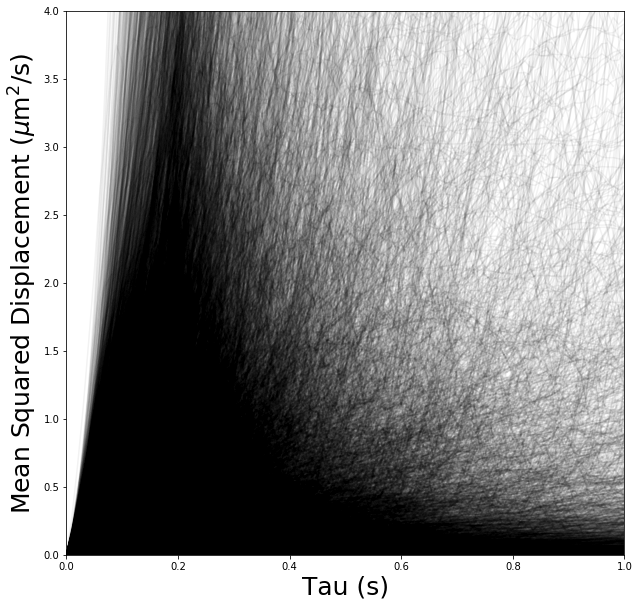

In [15]:
y = hm.plot_individual_msds(prefix, umppx=0.07, upload=True, y_range=4, x_range=1, remote_folder=folder, bucket='hpontes.data',
                     alpha=0.05)

Plotted NH2-PEG_t1_XY1_2_3 trajectories successfully.


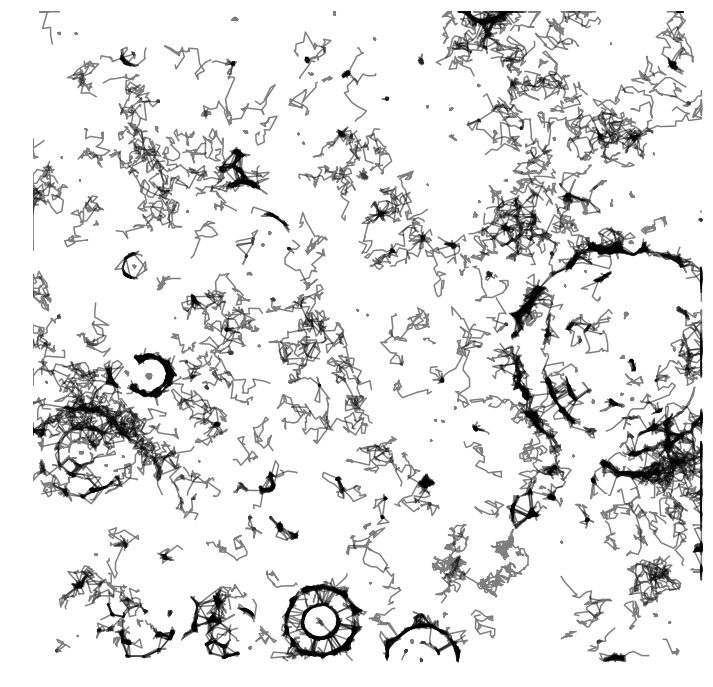

In [13]:
y = plot_trajectories_small(s_prefix, upload=False, alpha=0.5)

In [ ]:
def plot_individual_msds(prefix, x_range=100, y_range=20, umppx=0.16, fps=100.02, alpha=0.01, folder='.', upload=True,
                         remote_folder="01_18_Experiment", bucket='ccurtis.data', to_plot=500):

    merged = pd.read_csv('{}/msd_{}.csv'.format(folder, prefix))

    fig = plt.figure(figsize=(10, 10))
    particles = int(max(merged['Track_ID']))
    frames = int(max(merged['Frame']))
    y = np.zeros((particles+1, frames+1))
    for i in range(0, to_plot):
        y[i, :] = merged.loc[merged.Track_ID == i, 'MSDs']*umppx*umppx
        x = merged.loc[merged.Track_ID == i, 'Frame']/fps
        plt.loglog(x, y[i, :], 'k', alpha=alpha)

    #geo_mean = np.nanmean(ma.log(y), axis=0)
    #geo_SEM = stats.sem(ma.log(y), axis=0, nan_policy='omit')
    #plt.plot(x, np.exp(geo_mean), 'k', linewidth=4)
    #plt.plot(x, np.exp(geo_mean-geo_SEM), 'k--', linewidth=2)
    #plt.plot(x, np.exp(geo_mean+geo_SEM), 'k--', linewidth=2)
    plt.xlim(10**-2, 10)
    plt.ylim(10**-4, 10)
    plt.xlabel('Tau (s)', fontsize=25)
    plt.ylabel(r'Mean Squared Displacement ($\mu$m$^2$/s)', fontsize=25)

    outfile = '{}/msds_{}.png'.format(folder, prefix)
    #outfile2 = '{}/geomean_{}.csv'.format(folder, prefix)
    #outfile3 = '{}/geoSEM_{}.csv'.format(folder, prefix)
    fig.savefig(outfile, bbox_inches='tight')
    #np.savetxt(outfile2, geo_mean, delimiter=",")
    #np.savetxt(outfile3, geo_SEM, delimiter=",")
    #if upload==True:
    #    aws.upload_s3(outfile, remote_folder+'/'+outfile, bucket_name=bucket)
    #    aws.upload_s3(outfile2, remote_folder+'/'+outfile2, bucket_name=bucket)
    #    aws.upload_s3(outfile3, remote_folder+'/'+outfile3, bucket_name=bucket)
    #return geo_mean, geo_SEM
    return y

In [ ]:
merged = pd.read_csv('{}/msd_{}.csv'.format('.', prefix))

In [ ]:
msdss = pd.DataFrame(np.transpose(y))
msdss[list(range(10, 25))]

In [ ]:
def plot_trajectories(prefix, resolution=512, rows=4, cols=4, upload=True, to_plot=500, 
                      remote_folder = "01_18_Experiment", bucket='ccurtis.data'):
    """
    Plot trajectories in video.

    Parameters
    ----------
    prefix: string
        Prefix of file name to be plotted e.g. features_P1.csv prefix is P1.
    resolution: int
        Resolution of base image.  Only needed to calculate bounds of image.
    rows: int
        Rows of base images used to build tiled image.
    cols: int
        Columns of base images used to build tiled images.
    upload: boolean
        True if you want to upload to s3.

    """
    merged = pd.read_csv('msd_{}.csv'.format(prefix))
    particles = int(max(merged['Track_ID']))
    ires = resolution

    fig = plt.figure(figsize=(12, 12))
    for part in range(0, to_plot):
        x = merged[merged['Track_ID'] == part]['X']
        y = merged[merged['Track_ID'] == part]['Y']
        plt.plot(x, y, color='k', alpha=0.7)

    plt.xlim(0, ires*cols)
    plt.ylim(0, ires*rows)
    plt.axis('off')

    print('Plotted {} trajectories successfully.'.format(prefix))
    outfile = 'traj_{}.png'.format(prefix)
    fig.savefig(outfile, bbox_inches='tight')
    if upload == True:
        aws.upload_s3(outfile, remote_folder+'/'+outfile, bucket_name=bucket)

In [5]:
def plot_trajectories_small(prefix, resolution=512, rows=4, cols=4, upload=True, alpha=0.05,
                      remote_folder = "01_18_Experiment", bucket='ccurtis.data'):
    """
    Plot trajectories in video.

    Parameters
    ----------
    prefix: string
        Prefix of file name to be plotted e.g. features_P1.csv prefix is P1.
    resolution: int
        Resolution of base image.  Only needed to calculate bounds of image.
    rows: int
        Rows of base images used to build tiled image.
    cols: int
        Columns of base images used to build tiled images.
    upload: boolean
        True if you want to upload to s3.

    """
    #merged = pd.read_csv('Traj_{}.csv'.format(prefix))
    merged = ut.csv_to_pd('Traj_{}.csv'.format(prefix))
    particles = int(max(merged['Track_ID']))
    ires = resolution

    fig = plt.figure(figsize=(12, 12))
    for part in range(0, particles):
        sort = merged[merged['Track_ID'] == part].sort_values(by=['Frame'])
        x = sort['X']
        y = sort['Y']
        plt.plot(x, y, color='k', alpha=alpha)

    plt.xlim(0, ires)
    plt.ylim(0, ires)
    plt.axis('off')

    print('Plotted {} trajectories successfully.'.format(prefix))
    outfile = 'traj_{}.png'.format(prefix)
    fig.savefig(outfile, bbox_inches='tight')
    if upload == True:
        aws.upload_s3(outfile, remote_folder+'/'+outfile, bucket_name=bucket)

In [ ]:
merged = ut.csv_to_pd(traj)

In [ ]:
part = 1
sort = merged[merged['Track_ID'] == part].sort_values(by=['Frame'])
x = sort['X']
y = sort['Y']

In [ ]:
sort